<a href="https://colab.research.google.com/github/aeyjeyaryan/Deep-Learning/blob/main/Fine_Tuning(TransferLearning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with tensorflow. Part 2 : FINE TUNING

In [1]:
# check the use of a gpu
!nvidia-smi

Wed Jun 26 16:11:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

What we did here is the functions that were created earlier were put into a script and we just downloaded it

In [2]:
# Creating helper functions! (Importing from other notebooks)

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-26 16:11:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-06-26 16:11:52 (18.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions that are to be used
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Getting the dataset

This time we will use the pretrained models within tf.keras.applications

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
unzip_data("10_food_classes_10_percent.zip")

--2024-06-26 16:11:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   148MB/s    in 1.1s    

2024-06-26 16:11:57 (148 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Create training and test dir paths
train_dir= "/content/10_food_classes_10_percent/train"
test_dir= "/content/10_food_classes_10_percent/test"

In [6]:
#alternate to imagedatagenerator class (this one is more efficient)
import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)



Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# images ====>shape=(None, 224, 224, 3)
# labels ====>shape=(None, 10)

In [9]:
# class names of the dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# take will disect the batch and we're taking 1 means it will unravel a batch
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[5.33571434e+01 4.13571434e+01 2.73571434e+01]
   [5.10714264e+01 3.90714264e+01 2.50714283e+01]
   [4.57857132e+01 3.67857132e+01 2.17857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[5.38651161e+01 4.18651161e+01 2.78651142e+01]
   [5.11278687e+01 3.91278687e+01 2.51278687e+01]
   [4.57857132e+01 3.67857132e+01 2.17857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[5.45609055e+01 4.25609055e+01 2.85609055e+01]
   [5.20940666e+01 4.00940666e+01 2.60940685e+01]
   [4.67857132e+01 3.77857132e+01 2.27857132e+01]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  ...

  [[1.68274841e+01 3.18462682e+00 0.00000000e+00]
   [1

In [11]:
## Model 0 : Building a transfer learning model with keras function API (feature extraction here)

In [12]:
# 1. Create a base model with tf.keras.application

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model

base_model.trainable = False

# 3. Create inputs into out model

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. Normalize inputs

# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model

x = base_model(inputs)

# 6. Average pool the outputs
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with outputs
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240626-161206
Epoch 1/5
24/24 [==============================] - 17s 279ms/step - loss: 1.8928 - accuracy: 0.4093 - val_loss: 1.2962 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 5s 196ms/step - loss: 1.0864 - accuracy: 0.7720 - val_loss: 0.8551 - val_accuracy: 0.8388
Epoch 3/5
24/24 [==============================] - 4s 132ms/step - loss: 0.7820 - accuracy: 0.8227 - val_loss: 0.6773 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.6334 - accuracy: 0.8547 - val_loss: 0.6054 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 5s 179ms/step - loss: 0.5462 - accuracy: 0.8653 - val_loss: 0.5308 - val_accuracy: 0.8684


In [13]:
x.shape

TensorShape([None, 1280])

In [14]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.5519 - accuracy: 0.8632


[0.5518543720245361, 0.8632000088691711]

In [15]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [16]:
# since we have already "1 rescaling_8" in the model, we didn't add that x of rescaling line.

In [17]:
# summary of the model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [18]:
# summary of the whole model

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

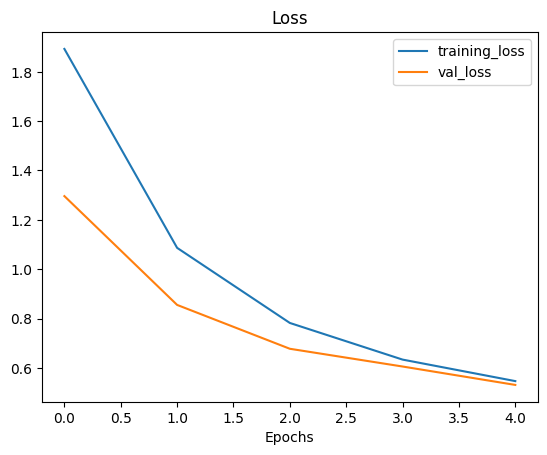

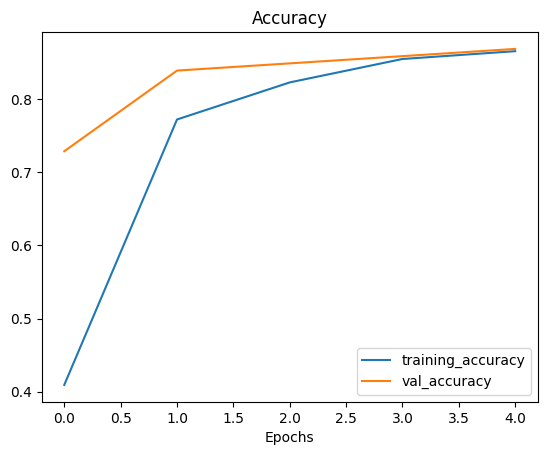

In [19]:
# check out the model's training curve

plot_loss_curves(history_0)

# getting a feature vector from a trained model


In [20]:
# Demonstration of global average pooling 2d layer

input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"input tensor:\n {input_tensor}\n")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)


input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [21]:
# pass the random tensor through a gloval average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Global average pooled tensor:\n {global_average_pooled_tensor}\n")

# check the shape of the tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled tensor: {global_average_pooled_tensor.shape}")

Global average pooled tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled tensor: (1, 3)


In [22]:
# replicating the globalaveragepool 2d layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## What is a featured Vector?

* A feature vector is a learned representation of an input data
(A compressed form of the input data based on how the model sees it).

* The output received from the model is known as featured vector.


* Data augmentation is the process of artificially generating new data from existing data, primarily to train new machine learning (ML) models.

# Running a series of transfer learning experiments

* We will train the model on 1% of the data.

1. model_1 - use feature extraction transfer learning with 1% of the training data with data augmentaion

2. model_2 use feature extraction transfer learning with 10% of the training with data augmentation

3. model_3 will use fine tuning transfer learning on 10% of the training data with data augmentation

4. model_4  will use fine tuning transfer learning on 100% of the training data with data augmentation

In [23]:
# download and unzip data -- preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

#using the helper function.py

unzip_data("10_food_classes_1_percent.zip")

--2024-06-26 16:12:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   128MB/s    in 1.0s    

2024-06-26 16:12:52 (128 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [24]:
# creating training ad test dirs

train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir = "/content/10_food_classes_1_percent/test"

In [25]:
# checking the shape
walk_through_dir("/content/10_food_classes_1_percent")


There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'

In [26]:
# setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
from os import name
# building data augmentation layer to use inside our model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation with horizontal flipping, rotation, zooms etc
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescaling(1./255)  # for models like resnet where rescale are not inbuilt
], name="data_augmentation")

## Visualize our data augmentation layer and see what happens to our data

(-0.5, 530.5, 330.5, -0.5)

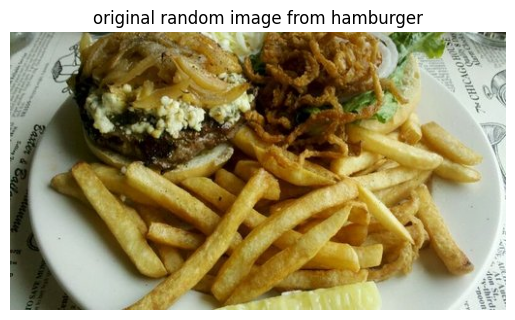

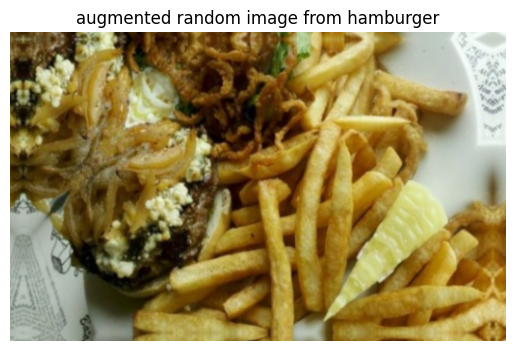

In [28]:
# take a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from {target_class}")
plt.axis(False)

# Plot out the augmented random image

augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image/255.))
plt.title(f"augmented random image from {target_class}")
plt.axis(False)

In [29]:
augmented_image

<tf.Tensor: shape=(1, 331, 531, 3), dtype=float32, numpy=
array([[[[120.9157   , 100.02482  ,  56.13113  ],
         [104.03227  ,  82.82883  ,  36.369    ],
         [ 83.425415 ,  60.69899  ,  13.574562 ],
         ...,
         [244.40105  , 254.67747  , 251.2171   ],
         [242.50618  , 253.49368  , 249.50027  ],
         [240.64409  , 251.64409  , 247.64409  ]],

        [[114.096245 ,  92.95898  ,  48.102135 ],
         [100.92605  ,  79.25994  ,  32.477737 ],
         [ 86.59685  ,  64.029335 ,  15.4648905],
         ...,
         [243.39839  , 253.98158  , 250.28157  ],
         [242.55643  , 253.4373   , 249.38033  ],
         [241.67226  , 252.66101  , 248.6554   ]],

        [[109.02227  ,  87.44338  ,  41.4331   ],
         [ 95.6365   ,  73.370186 ,  26.290314 ],
         [ 86.5597   ,  62.78647  ,  15.038583 ],
         ...,
         [240.4701   , 250.79504  , 246.59395  ],
         [241.99973  , 251.91315  , 247.36986  ],
         [242.83537  , 253.15425  , 248.81369 

## model 1 : feature extraction transfer learning on the 1% data



In [30]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# augmentation layer
x = data_augmentation(inputs)

# base model
x = base_model(x, training=False)

# pool output features
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# make a model (with inputs and outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240626-161259
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.4140 - accuracy: 0.0714 - val_loss: 2.2755 - val_accuracy: 0.1530
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2006 - accuracy: 0.1857 - val_loss: 2.1457 - val_accuracy: 0.2451
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 2.0251 - accuracy: 0.3429 - val_loss: 2.0319 - val_accuracy: 0.3355
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.8514 - accuracy: 0.4286 - val_loss: 1.9310 - val_accuracy: 0.3947
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.7173 - accuracy: 0.5429 - val_loss: 1.8534 - val_accuracy: 0.4227


In [31]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [32]:
# Evaluate on full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 5s 61ms/step - loss: 1.8691 - accuracy: 0.4112


[1.8691424131393433, 0.41119998693466187]

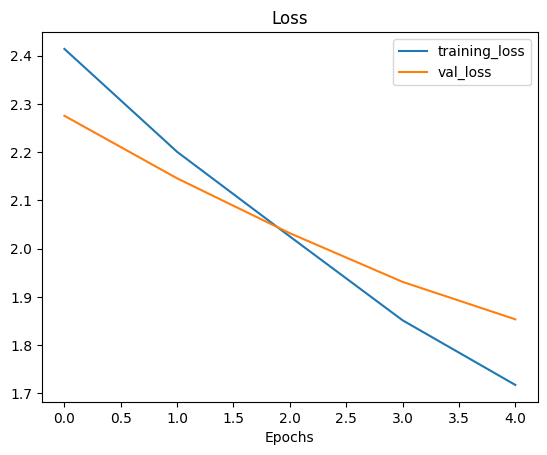

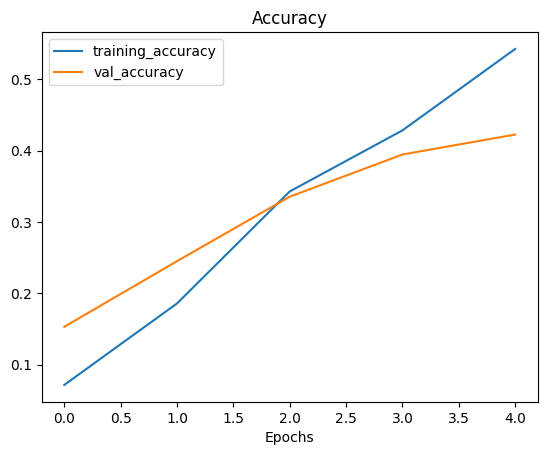

In [33]:
# visualize the loss curve
plot_loss_curves(history_1_percent)

## Model 2 : feature extraction tl model with 10% data and data augmentation

In [34]:
train_dir_10_percent = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [35]:
# set data inputs
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE
                                                                            )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE,
                                                               )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [36]:
# create the model 2 with data augmentation
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # rescaling is built in the efficientnet
],name='data_augmentation')

In [37]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

## Creating a modelcheckpoint callback

* Callbacks are a tool which can add helpful functionality to the models during training evaluation or inference

* Some of them are (tensorboard, modelcheckpointing, earlystopping)

* Mode checkpointing saves your model as it trains so you can stop traiinin. if needed and come back to continue off where you left. helpful if training takes a long time and can't be done in one sitting. ( the weights if not the entire model)

walk away eat a meal and continue back type thing

In [39]:
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a model checkpoint callback that saves
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  save_best_only=False,
                                                  save_freq="epoch", #save every epoch
                                                  verbose=1)

In [40]:
#fit the model saving checpoints every epoch

initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                            epochs=initial_epochs,
                                            validation_data=test_data,
                                            validation_steps=int(0.25 * len(test_data)),
                                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                   experiment_name="10_percent_data_aug"),
                                                     checkpoint])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240626-161347
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9678 - accuracy: 0.3587
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 30s 933ms/step - loss: 1.9678 - accuracy: 0.3587 - val_loss: 1.3933 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2652 - accuracy: 0.7253
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 748ms/step - loss: 1.2652 - accuracy: 0.7253 - val_loss: 0.9390 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9901 - accuracy: 0.7627
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 745ms/step - loss: 0.9901 - accuracy: 0.7627 - val_loss: 0.7511 - val_accuracy: 0.8174
E

In [41]:
# model 2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 62ms/step - loss: 0.6177 - accuracy: 0.8440


[0.6176671385765076, 0.843999981880188]

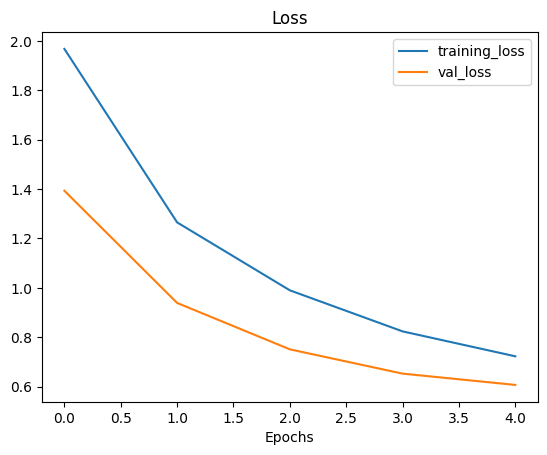

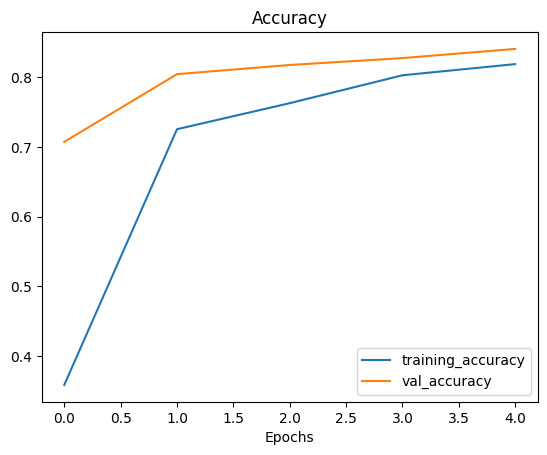

In [42]:
# plot the model loss curve
plot_loss_curves(history_10_percent_data_aug)

# loading in the checkpointed weights

* Loading in checkpointed weights return a model to a specific checkpoint

In [43]:
# load in saved model wts and evaluate models
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

58/79 [=====================>........] - ETA: 1s - loss: 0.6207 - accuracy: 0.8411

## Model 3: Fine Tuning an existing model on 10% data

* Fine tuning means unfreezing a few layer in a model and keeping the other layers frozen.
* Fine tuning usually works best after training a feature extraction model for a few epochs with large amount of custom data.


In [ ]:
# Layers in the loaded model
model_2.layers

In [ ]:
# are they trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
# how many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

In [ ]:
model_3 = model_2

In [ ]:
# Ensure the base model is part of model_2
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable = False

# Check the trainable status of the layers
for layer in model_2.layers:
    print(f"{layer.name}: {layer.trainable}")

# Recompile the model after making changes
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=["accuracy"]
)


In [ ]:
# check for trainable layers
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
print(len(model_2.trainable_variables))

In [ ]:
# fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# refit the model
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = fine_tune_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          initial_epoch = history_10_percent_data_aug.epoch[-1], #start training from previous point
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_fine_tune_last_10")])

In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)


In [ ]:
# download and unzip 10 classes of food101 data with all images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")


In [ ]:
#set up train and test dir
train_dir_all_data = "/content/10_food_classes_all_data/train"
test_dir = "/content/10_food_classes_all_data/test"


In [ ]:
# count of images
walk_through_dir("10_food_classes_all_data")

In [ ]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)

In [ ]:
# evaluate the model 2 (fine tuned version of 10% data)

model_2.evaluate(test_data)

In [ ]:
results_fine_tune_10_percent

* To train a fine-tuning model we need to revert model_2 back it feature extraction wts.

In [ ]:
# check tunable layers in the entire model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# into the base_model and see what layers are trainable (efficientb0)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# continue to train and fine tune the model to our data (100%)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_all_data,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                   experiment_name="full_10_classes_fine_tune_last_10")])


In [ ]:
# evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)